In [1]:
# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Load the predictions of models, load real labels and count the F1-values

### Version for Hatespeech

In [15]:
#from tensorflow import keras
#import tensorflow as tf
#import tensorflow_hub as hub

import os
import re
import pandas as pd

from sklearn.model_selection import train_test_split
import pandas as pd

from datetime import datetime

# predicted logits to distribution
import numpy as np

# confusion matrix
from matplotlib import pyplot as plt
import itertools
# vs import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score

# avoid printing e-notation, such as 9.9687493e-01. Instead print 0.9968
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.4f}'.format})

In [3]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
dataset = 'hatespeech'

In [5]:
current = os.getcwd()
basefolder = current + '/dataset_'+ dataset+'/'
datafolder = basefolder + 'data/'  # for example /dataset_businessnews/data/
print(basefolder)

infolder =  basefolder + 'input/'
outfolder = basefolder + 'output/'

/home/max/git/modelcompare/dataset_hatespeech/


### True labels

In [6]:
test = pd.read_csv(basefolder+'input/test.csv'  ,sep='\t', header = None)
test.columns  = ['id','label', 'text']
true_labels = test['label'].astype(int)  # they are type object, turn to int

In [7]:
test.head()

,id,label,text
0,23437,1,Wizard turned into a hoe after a break up
1,17813,1,RT MENTION : Captain Kirk hoe !
2,2561,1,MENTION bruh did go out like a bitch thoe lol...
3,18228,1,RT MENTION : RT MENTION : when you tryna g...
4,23030,1,Well I wish I could shoot the shit wit u bitch...


In [8]:
# Counts, Majority

# 0 - hate speech
# 1 - offensive language
# 2 - neither

from collections import Counter
Counter(true_labels)


Counter({1: 2279, 2: 548, 0: 173})

In [9]:
2279 / (2279+548+173)
0.7596666666666667

# Majority prediction gives accuracy 0.75966

0.7596666666666667

In [10]:
### count F1 for majority class.
# majority, 0.76 is 1

length = len(true_labels)
#yhat = pd.Series(np.ones(length).astype(int))

yhat = pd.Series( [1] * length) # value 1, times length, turned into Series
f1_majority = f1_score(true_labels, yhat, average='micro')
print('f1 majority:',f1_majority)

precision_majority = precision_score(true_labels, yhat, average='micro', labels=[0,1,2])
recall_majority = recall_score(true_labels, yhat, average='micro')

#names.append('Majority')
#scores.append(f1)
#traintimes.append(0)
#precisions.append()
#recalls.append(recall_score(true_labels, yhat, average='micro'))

f1 majority: 0.7596666666666667


In [11]:
import shelve
def loadResults_tfhub():
    import shelve
    shelf = shelve.open(outfolder+"all.shlf") # the same filename that you used before, please
    new = shelf["all"]
    shelf.close()
    return new

In [12]:
def saveResults_flair(all, name='all_default'):
    filename= name+'.shlf'
    shelf = shelve.open(outfolder+filename)
    #shelf = shelve.open("all_flair.shlf")
    # serializing
    #shelf["all_flair"] = all_flair
    shelf[name] = all_flair
    shelf.close() # you must close the shelve file!!!

In [13]:
def loadResults_flair(name='all_default'):
    filename= name+'.shlf'
    shelf = shelve.open(outfolder+filename) 
    new = shelf[name]
    shelf.close()
    return new

In [38]:
outfolder

'/home/max/git/newcombined/dataset_hatespeech/output/'

### LOAD all sizes and combine

In [53]:
    # PROCESS LISTS FOR ONE SIZE OF TRAININ DATA
    
def unpack(all):
        # FLAIR
        # unpack values from dict / list structure: names and f1-scores of models.
        names = []
        scores= []
        traintimes=[]
        predtimes=[]
        precisions = []
        recalls = []

        for i in range(len(all)):
            yhat = all[i]['labels']
            all[i]['f1'] = f1_score(true_labels, yhat, average='micro')
    
            names.append(all[i]['model'])
            scores.append(f1_score(true_labels, yhat, average='micro'))
            traintimes.append(all[i]['traintime'])
            predtimes.append(all[i]['predtime3k'])
            precisions.append(precision_score(true_labels, yhat, average='micro', labels=[0,1,2]))
            recalls.append(recall_score(true_labels, yhat, average='micro'))            
        
        return(names, scores, traintimes, predtimes, precisions, recalls)
    

In [113]:
from sklearn.metrics import precision_score, recall_score

sizes = [100, 200, 500, 1000, 3000, 7000, 18783]


#randomized 501 to compare and confirm 
#sizes = [100, 200, 500, 1000, 1001, 3000, 7000, 18783]

#sizes = [100, 200, 500, 1000, 3000, 18783]
#sizes = [100]

first= True

namestart = 'FINAL_flair_all_trainsz_'
for size in sizes:
    name = namestart+str(size)
    print(name)
    
    #LOAD IT
    all = loadResults_flair(name)

    names, scores, traintimes, predtimes, precisions, recalls = unpack(all)
    


    
    df_size = pd.DataFrame(list(zip(names, scores)), #, traintimes, precisions, recalls
                   #columns =['Name', 'score', 'traintime', 'precision', 'recall']) 
            #columns =['Model', 'trn_'+str(size)]) 
             columns =['Model', str(size)]) 

    if first:
        df = df_size
        first=False
    else:
        df = pd.merge(df, df_size, on='Model')
    

FINAL_flair_all_trainsz_100
FINAL_flair_all_trainsz_200
FINAL_flair_all_trainsz_500
FINAL_flair_all_trainsz_1000
FINAL_flair_all_trainsz_3000
FINAL_flair_all_trainsz_7000
FINAL_flair_all_trainsz_18783


In [114]:
# add column with f1 value of majority class as baseline
df.insert(1, '0', 0.760)

In [115]:
# manually fix name of bert 
df.replace('bert-base-uncased', 'bert-base-cased', inplace=True)

In [116]:
pd.options.display.float_format = "{:,.3f}".format
df

,Model,0,100,200,500,1000,3000,7000,18783
0,glove,0.760,0.760,0.763,0.768,0.798,0.862,0.885,0.892
1,fasttext web-crawl,0.760,0.760,0.761,0.764,0.837,0.902,0.907,0.914
2,fasttext news/wiki,0.760,0.760,0.760,0.760,0.767,0.879,0.895,0.903
3,en-twitter,0.760,0.765,0.770,0.797,0.810,0.892,0.902,0.907
4,elmo,0.760,0.776,0.787,0.792,0.812,0.866,0.902,0.909
5,Flair,0.760,0.760,0.760,0.761,0.776,0.787,0.812,0.829
6,bert-base-cased,0.760,0.775,0.793,0.816,0.797,0.888,0.907,0.914
7,BytePairEmbedding,0.760,0.765,0.766,0.777,0.806,0.867,0.885,0.899
8,gpt-1,0.760,0.789,0.791,0.816,0.879,0.892,0.905,0.917


#### Write pandas DF into latex table

In [117]:
# https://tex.stackexchange.com/questions/394123/export-dataframe-to-table-in-latex

with open('mytable_f1_trainsize.tex','w') as tf:
    tf.write(df.to_latex())

In [118]:
#df.to_latex()

### Present it as a graph

In [119]:
# Write out before setting Model as inxed? puts them headers on 2 lines
df = df.set_index('Model')

In [120]:
df

,0,100,200,500,1000,3000,7000,18783
Model,,,,,,,,
glove,0.760,0.760,0.763,0.768,0.798,0.862,0.885,0.892
fasttext web-crawl,0.760,0.760,0.761,0.764,0.837,0.902,0.907,0.914
fasttext news/wiki,0.760,0.760,0.760,0.760,0.767,0.879,0.895,0.903
en-twitter,0.760,0.765,0.770,0.797,0.810,0.892,0.902,0.907
elmo,0.760,0.776,0.787,0.792,0.812,0.866,0.902,0.909
Flair,0.760,0.760,0.760,0.761,0.776,0.787,0.812,0.829
bert-base-cased,0.760,0.775,0.793,0.816,0.797,0.888,0.907,0.914
BytePairEmbedding,0.760,0.765,0.766,0.777,0.806,0.867,0.885,0.899
gpt-1,0.760,0.789,0.791,0.816,0.879,0.892,0.905,0.917


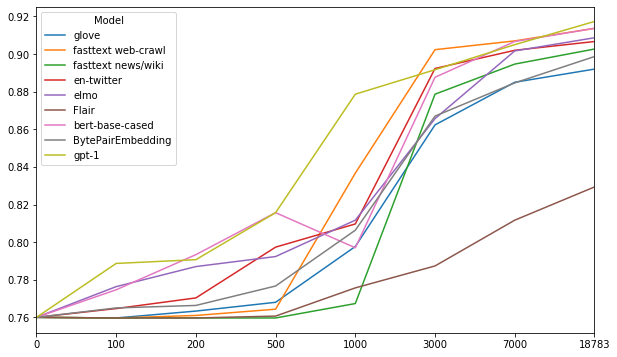

In [121]:
df.T.plot(figsize=(10,6))

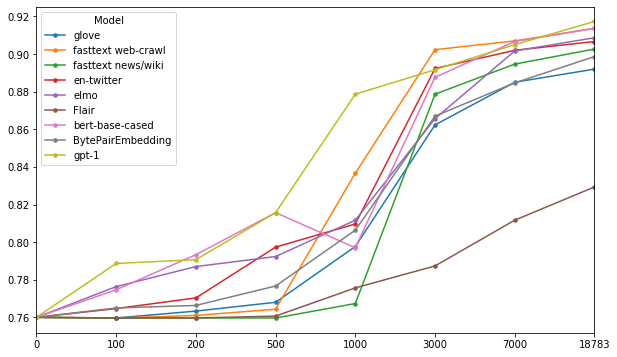

In [122]:
# colormap='jet'
#df.T.plot(figsize=(10,6), title="F1 per train samples: Hatespeech data", marker='.', markersize=7)
df.T.plot(figsize=(10,6), marker='.', markersize=7)

#### Single, original

In [132]:
### count F1 for majority class.
# majority, 0.76 is 1

length = len(true_labels)
#yhat = pd.Series(np.ones(length).astype(int))

yhat = pd.Series( [1] * length) # value 1, times length, turned into Series
f1 = f1_score(true_labels, yhat, average='micro')
print(f1)

names.append('Majority')
scores.append(f1)
traintimes.append(0)
precisions.append(precision_score(true_labels, yhat, average='micro', labels=[0,1,2]))
recalls.append(recall_score(true_labels, yhat, average='micro'))

0.7596666666666667


In [133]:
names

['glove',
 'fasttext web-crawl',
 'fasttext news/wiki',
 'en-twitter',
 'elmo',
 'Flair',
 'bert-base-uncased',
 'BytePairEmbedding',
 'gpt-1',
 'Majority',
 'Majority']

In [79]:
scores

[0.892,
 0.9136666666666666,
 0.9026666666666666,
 0.9066666666666666,
 0.9086666666666666,
 0.8293333333333334,
 0.9136666666666666,
 0.8986666666666666,
 0.9173333333333333]

### Traintimes, prediction times

In [82]:
names

['glove',
 'fasttext web-crawl',
 'fasttext news/wiki',
 'en-twitter',
 'elmo',
 'Flair',
 'bert-base-cased',
 'BytePairEmbedding',
 'gpt-1']

In [83]:
predtimes

[4.842005729675293,
 5.090792655944824,
 4.955539703369141,
 5.2229108810424805,
 130.29307055473328,
 93.0849277973175,
 68.86565017700195,
 8.170584917068481,
 65.25658059120178]

In [86]:
# dictionary of lists  
dict = {'Model': names, 'Traintime': traintimes, 'Prediction time': predtimes}  
    
df_times = pd.DataFrame(dict) 
df_times.set_index('Model') 


#df_times['Prediction time'] = df_times['Prediction time'] / 3000
df_times['Prediction time'] = df_times['Prediction time'] / 3 # per 1000 sample
df_times


,Model,Traintime,Prediction time
0,glove,71.011,1.614
1,fasttext web-crawl,208.219,1.697
2,fasttext news/wiki,209.539,1.652
3,en-twitter,129.847,1.741
4,elmo,77.256,43.431
5,Flair,56.918,31.028
6,bert-base-cased,259.950,22.955
7,BytePairEmbedding,61.296,2.724
8,gpt-1,198.082,21.752


#### FLAIR

In [11]:
# in folder dataset_hatespeech/output/    # can see name of resultfile there
#name = 'all_flair_512LSTM_2ep'
name = 'all_flair_512LSTM_15ep_8model'
name = 'FINAL_flair_all_trainsz_100'

#name = 'FINAL_flair_all_trainsz_200'
#name = 'FINAL_flair_all_trainsz_500'

name = 'FINAL_flair_all_trainsz_1000'

name = 'FINAL_flair_all_trainsz_18783'

name = 'FINAL_flair_all_trainsz_100'

all_flair = loadResults_flair(name)
all = all_flair
len(all_flair)


9

In [28]:
from sklearn.metrics import precision_score, recall_score
# FLAIR
# unpack values from dict / list structure: names and f1-scores of models.
names = []
scores= []
traintimes=[]
precisions = []
recalls = []

for i in range(len(all)):
    yhat = all[i]['labels']
    all[i]['f1'] = f1_score(true_labels, yhat, average='micro')
    #all[i]['precision'] = precision_score(true_labels, yhat, average='micro', labels=[0,1,2])
    #all[i]['recall'] = recall_score(true_labels, yhat, average='micro')
    
    names.append(all[i]['model'])
    scores.append(f1_score(true_labels, yhat, average='micro'))
    traintimes.append(all[i]['traintime'])
    precisions.append(precision_score(true_labels, yhat, average='micro', labels=[0,1,2]))
    recalls.append(recall_score(true_labels, yhat, average='micro'))


#### TF-hlub

In [87]:
all_tfhub = loadResults_tfhub()
len(all_tfhub)
all = all_tfhub

# TF-HUB
# unpack values from dict / list structure: names and f1-scores of models.
names = []
scores= []
#traintimes=[]

for i in range(len(all)):
    yhat = all[i]['labels']
    all[i]['f1'] = f1_score(true_labels, yhat, average='micro')
    
    names.append(all[i]['model'])
    scores.append(f1_score(true_labels, yhat, average='micro'))
    #traintimes.append(all[i]['traintime'])

#### Common

In [13]:
names

['glove',
 'fasttext web-crawl',
 'fasttext news/wiki',
 'en-twitter',
 'elmo',
 'Flair',
 'bert-base-uncased',
 'BytePairEmbedding',
 'gpt-1']

In [14]:
names

['glove',
 'fasttext web-crawl',
 'fasttext news/wiki',
 'en-twitter',
 'elmo',
 'Flair',
 'bert-base-uncased',
 'BytePairEmbedding',
 'gpt-1']

In [15]:
scores

[0.7596666666666667,
 0.7596666666666667,
 0.7596666666666667,
 0.7646666666666667,
 0.7763333333333333,
 0.7596666666666667,
 0.7746666666666666,
 0.765,
 0.7886666666666666]

In [75]:
scores

[0.7976666666666666,
 0.8366666666666667,
 0.7673333333333334,
 0.8096666666666666,
 0.8116666666666666,
 0.7756666666666665,
 0.797,
 0.8063333333333333,
 0.8786666666666667]

In [120]:
traintimes

[420.35936999320984,
 512.5102701187134,
 490.92159509658813,
 505.1277804374695,
 557.0145864486694,
 521.807178735733,
 1232.1364481449127,
 638.7153763771057,
 1123.3866958618164]

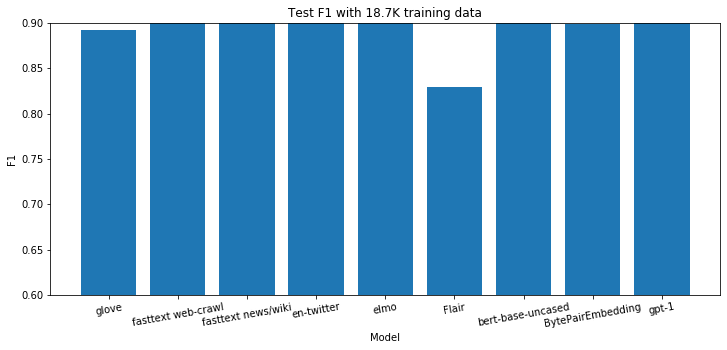

In [110]:
# Bar
index = np.arange(len(scores))
values = scores
labels = names

plt.figure(figsize=(12,5))
plt.ylim(0.6, 0.90) # is set, but not effecting bar
plt.bar(index, values)
plt.xlabel('Model', fontsize=10)
plt.ylabel('F1', fontsize=10)
plt.xticks(index, labels, fontsize=10, rotation=10)
plt.title('Test F1 with 18.7K training data')

plt.show()

#from importlib import reload  
#reload(plt)

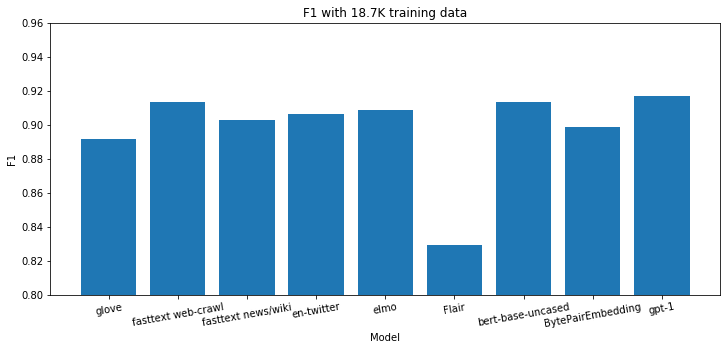

In [119]:
# Bar
index = np.arange(len(scores))
values = scores
labels = names

plt.figure(figsize=(12,5))
plt.ylim(0.80, 0.96) # is set, but not effecting bar
plt.bar(index, values)
plt.xlabel('Model', fontsize=10)
plt.ylabel('F1', fontsize=10)
plt.xticks(index, labels, fontsize=10, rotation=10)
plt.title('F1 with 18.7K training data')

plt.show()

#from importlib import reload  
#reload(plt)

In [18]:
del labels[3:6]
del values[3:6]
del labels[3]
del values[3]

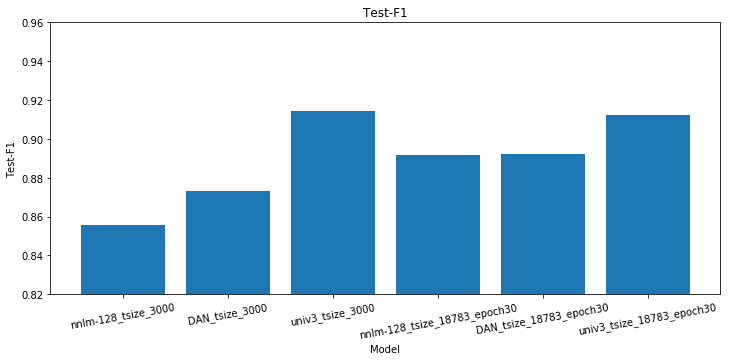

In [19]:
# Bar
index = np.arange(len(scores))
values = scores
labels = names

plt.figure(figsize=(12,5))
plt.ylim(0.82, 0.96) # is set, but not effecting bar
plt.bar(index, values)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Test-F1', fontsize=10)
plt.xticks(index, labels, fontsize=10, rotation=10)
plt.title('Test-F1')

plt.show()

In [98]:
#del labels[3:5]
#del values[3:5]

### Turn into dataframe

In [52]:
# input list containing dictionaries: all[0]['labels'] where labels are on 2nd level
# output: raise the labels-lists into 1st level and turn into DataFrame

labels = []
for i in range(len(names)): #(len(all))
    labels.append(all[i]['labels'])

labels = pd.DataFrame(labels).T
labels.columns= names
#lab


### Correlation between predicted labels

In [53]:
labels.corr()

,glove,fasttext web-crawl,fasttext news/wiki,en-twitter,elmo,Flair,bert-base-uncased,BytePairEmbedding,gpt-1
glove,1.000,0.831,0.814,0.817,0.786,0.554,0.786,0.782,0.775
fasttext web-crawl,0.831,1.000,0.886,0.897,0.844,0.558,0.856,0.810,0.845
fasttext news/wiki,0.814,0.886,1.000,0.867,0.798,0.578,0.838,0.776,0.805
en-twitter,0.817,0.897,0.867,1.000,0.835,0.585,0.849,0.793,0.819
elmo,0.786,0.844,0.798,0.835,1.000,0.547,0.844,0.808,0.825
Flair,0.554,0.558,0.578,0.585,0.547,1.000,0.578,0.525,0.516
bert-base-uncased,0.786,0.856,0.838,0.849,0.844,0.578,1.000,0.813,0.810
BytePairEmbedding,0.782,0.810,0.776,0.793,0.808,0.525,0.813,1.000,0.780
gpt-1,0.775,0.845,0.805,0.819,0.825,0.516,0.810,0.780,1.000


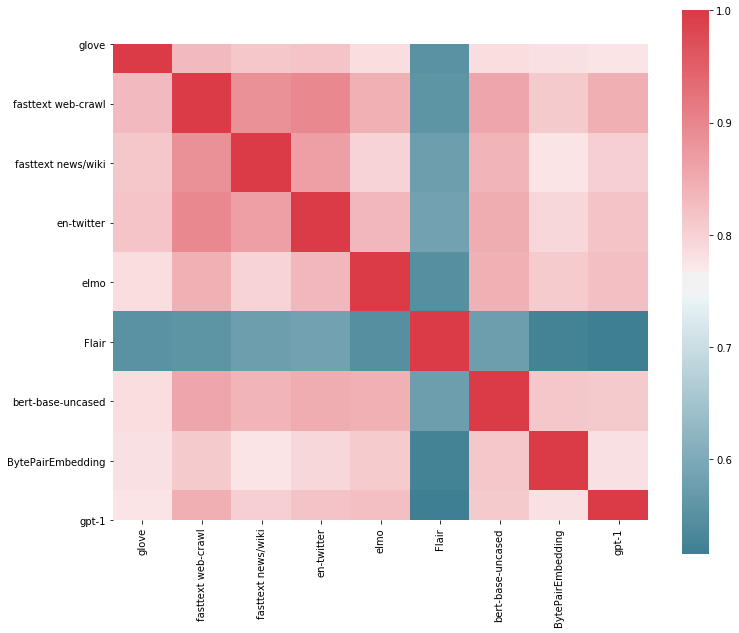

In [54]:
pick = labels
import seaborn as sns

#f, ax = plt.subplots(figsize=(10, 8))
f, ax = plt.subplots(figsize=(12, 10))
corr = pick.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

#### Flair is very low cor with others - remove it to use the color shades better

In [29]:
labels

,glove,fasttext web-crawl,fasttext news/wiki,en-twitter,elmo,bert-base-uncased,BytePairEmbedding,gpt-1
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
2995,1,1,1,1,1,1,1,1
2996,2,2,2,2,2,2,2,2
2997,1,1,1,1,1,1,1,1
2998,1,1,2,1,1,1,1,1


In [55]:
del labels['Flair']

In [57]:
labels.corr()

,glove,fasttext web-crawl,fasttext news/wiki,en-twitter,elmo,bert-base-uncased,BytePairEmbedding,gpt-1
glove,1.000,0.831,0.814,0.817,0.786,0.786,0.782,0.775
fasttext web-crawl,0.831,1.000,0.886,0.897,0.844,0.856,0.810,0.845
fasttext news/wiki,0.814,0.886,1.000,0.867,0.798,0.838,0.776,0.805
en-twitter,0.817,0.897,0.867,1.000,0.835,0.849,0.793,0.819
elmo,0.786,0.844,0.798,0.835,1.000,0.844,0.808,0.825
bert-base-uncased,0.786,0.856,0.838,0.849,0.844,1.000,0.813,0.810
BytePairEmbedding,0.782,0.810,0.776,0.793,0.808,0.813,1.000,0.780
gpt-1,0.775,0.845,0.805,0.819,0.825,0.810,0.780,1.000


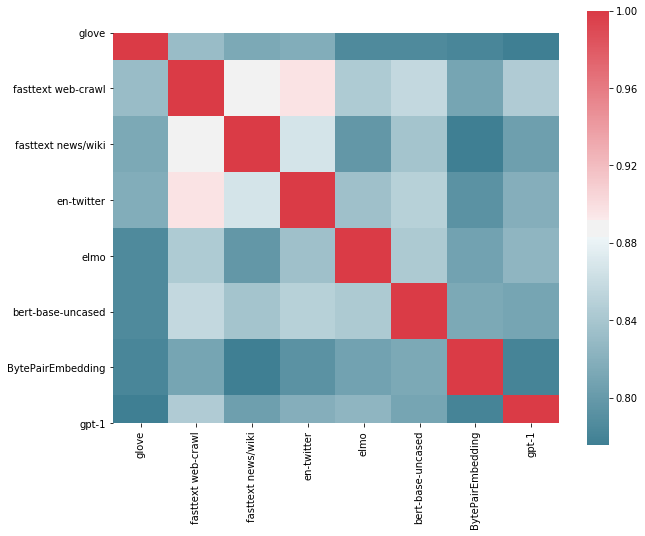

In [56]:
pick = labels
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
#f, ax = plt.subplots(figsize=(12, 10))
corr = pick.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [25]:
# last 3 columns
pick = labels.iloc[:, 3:]

In [26]:
probs = []
for i in range(len(names)): #(len(all))
    probs.append(all[i]['probs'])

probs = pd.DataFrame(probs).T
probs.columns= names
probs


,nnlm-128_tsize_3000,DAN_tsize_3000,univ3_tsize_3000,nnlm-128_tsize_18783_epoch30,DAN_tsize_18783_epoch30,univ3_tsize_18783_epoch30
0,"[4.233589e-05, 0.9999193, 3.840332e-05]","[1.6480626e-05, 0.9998909, 9.264603e-05]","[6.398087e-05, 0.9998853, 5.0707247e-05]","[0.00013908364, 0.9998254, 3.547703e-05]","[2.5715732e-05, 0.9998716, 0.000102616505]","[7.91436e-05, 0.9998338, 8.701929e-05]"
1,"[0.0013433183, 0.99797875, 0.0006780409]","[7.580178e-05, 0.96989506, 0.030029025]","[0.0001076711, 0.999806, 8.637823e-05]","[0.002030536, 0.99750996, 0.00045953243]","[2.547616e-05, 0.9989743, 0.0010002507]","[7.870038e-05, 0.9997701, 0.000151296]"
2,"[0.0011234806, 0.99871135, 0.00016510795]","[2.4509067e-05, 0.99997044, 5.0195786e-06]","[4.7642898e-05, 0.9999232, 2.913791e-05]","[0.0006725391, 0.99926144, 6.598066e-05]","[1.7972814e-05, 0.999974, 8.038951e-06]","[6.0237904e-05, 0.9999143, 2.548163e-05]"
3,"[0.0004791329, 0.9995173, 3.5879834e-06]","[1.3438928e-05, 0.99997985, 6.728323e-06]","[3.8377642e-05, 0.99993515, 2.6411251e-05]","[0.0003392862, 0.9996592, 1.5918495e-06]","[1.8328115e-05, 0.9999672, 1.4433712e-05]","[4.4898494e-05, 0.9999287, 2.633073e-05]"
4,"[3.1970467e-05, 0.99996805, 7.1044792e-09]","[1.818452e-05, 0.999979, 2.731076e-06]","[6.852479e-05, 0.99991035, 2.1157512e-05]","[4.3006254e-05, 0.99995697, 8.022627e-09]","[1.7900435e-05, 0.9999765, 5.5927703e-06]","[7.507247e-05, 0.9999107, 1.421926e-05]"
5,"[0.081907175, 0.7386889, 0.17940396]","[0.0016064331, 0.005709461, 0.9926842]","[0.0004184056, 0.9995516, 3.00833e-05]","[0.08427183, 0.8487675, 0.06696065]","[0.0026555285, 0.06760905, 0.9297355]","[0.00016169962, 0.99982136, 1.6898892e-05]"
6,"[0.0006111432, 0.9598467, 0.03954213]","[1.0904048e-05, 0.999979, 1.0073294e-05]","[4.641684e-05, 0.99991405, 3.959844e-05]","[0.001172376, 0.9711367, 0.027690923]","[2.252558e-05, 0.99995816, 1.9321673e-05]","[5.2135645e-05, 0.99991536, 3.253769e-05]"
7,"[8.144646e-07, 0.9998646, 0.00013461642]","[0.00010322058, 0.98762506, 0.012271626]","[4.8737867e-05, 0.9998951, 5.6094e-05]","[2.1608248e-06, 0.99978226, 0.00021563252]","[0.00030092022, 0.9585573, 0.04114188]","[6.164825e-05, 0.9998791, 5.9188635e-05]"
8,"[0.00034172254, 0.9969459, 0.0027123827]","[1.3682003e-05, 0.99988484, 0.0001014915]","[0.0001048133, 0.9995121, 0.00038309305]","[0.00057175703, 0.9981173, 0.0013109304]","[1.6481239e-05, 0.99988806, 9.542799e-05]","[6.790512e-05, 0.99990237, 2.9676981e-05]"
9,"[4.506633e-05, 0.9999548, 1.6939906e-07]","[6.86458e-06, 0.9999902, 2.8723064e-06]","[4.578529e-05, 0.99992275, 3.144341e-05]","[7.477624e-05, 0.99992514, 1.1235904e-07]","[5.6351914e-06, 0.9999902, 4.1621734e-06]","[6.1978855e-05, 0.9999176, 2.0371614e-05]"


In [30]:
# last 3 columns
probs = probs.iloc[:, 3:]

In [32]:
probs

,nnlm-128_tsize_18783_epoch30,DAN_tsize_18783_epoch30,univ3_tsize_18783_epoch30
0,"[0.00013908364, 0.9998254, 3.547703e-05]","[2.5715732e-05, 0.9998716, 0.000102616505]","[7.91436e-05, 0.9998338, 8.701929e-05]"
1,"[0.002030536, 0.99750996, 0.00045953243]","[2.547616e-05, 0.9989743, 0.0010002507]","[7.870038e-05, 0.9997701, 0.000151296]"
2,"[0.0006725391, 0.99926144, 6.598066e-05]","[1.7972814e-05, 0.999974, 8.038951e-06]","[6.0237904e-05, 0.9999143, 2.548163e-05]"
3,"[0.0003392862, 0.9996592, 1.5918495e-06]","[1.8328115e-05, 0.9999672, 1.4433712e-05]","[4.4898494e-05, 0.9999287, 2.633073e-05]"
4,"[4.3006254e-05, 0.99995697, 8.022627e-09]","[1.7900435e-05, 0.9999765, 5.5927703e-06]","[7.507247e-05, 0.9999107, 1.421926e-05]"
5,"[0.08427183, 0.8487675, 0.06696065]","[0.0026555285, 0.06760905, 0.9297355]","[0.00016169962, 0.99982136, 1.6898892e-05]"
6,"[0.001172376, 0.9711367, 0.027690923]","[2.252558e-05, 0.99995816, 1.9321673e-05]","[5.2135645e-05, 0.99991536, 3.253769e-05]"
7,"[2.1608248e-06, 0.99978226, 0.00021563252]","[0.00030092022, 0.9585573, 0.04114188]","[6.164825e-05, 0.9998791, 5.9188635e-05]"
8,"[0.00057175703, 0.9981173, 0.0013109304]","[1.6481239e-05, 0.99988806, 9.542799e-05]","[6.790512e-05, 0.99990237, 2.9676981e-05]"
9,"[7.477624e-05, 0.99992514, 1.1235904e-07]","[5.6351914e-06, 0.9999902, 4.1621734e-06]","[6.1978855e-05, 0.9999176, 2.0371614e-05]"


### Cosine distance of 2 models

In [129]:
def euclidean_distance(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

In [133]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [131]:
# or different definition. likely requires aa = a.reshape(1,3)
# from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#import scipy.spatial.distance as SSD

In [34]:
probs.iloc[0]

nnlm-128_tsize_18783_epoch30      [0.00013908364, 0.9998254, 3.547703e-05]
DAN_tsize_18783_epoch30         [2.5715732e-05, 0.9998716, 0.000102616505]
univ3_tsize_18783_epoch30           [7.91436e-05, 0.9998338, 8.701929e-05]
Name: 0, dtype: object

In [91]:
test_a = probs.iloc[0][0]
test_b = probs.iloc[0][1]
print(test_a, test_b)

[0.0001 0.9998 0.0000] [0.0000 0.9999 0.0001]


In [134]:
cosine_similarity(test_a, test_b) # cosine of 0 is 1.

0.15028952

In [136]:
euclidean_distance(test_a, test_b)


1.1667262

In [ ]:
#### too near each other, cos sim is 1 differenc eat 3-4th decimal only

In [93]:
test_a = probs.iloc[5][0]
test_b = probs.iloc[5][1]
print(test_a, test_b)

[0.0843 0.8488 0.0670] [0.0027 0.0676 0.9297]


In [94]:
cosine_similarity(test_a, test_b)

0.15028952

In [130]:
# save the names and change easier to assign
#savenames = probs.columns
savenames

Index(['nnlm-128_tsize_18783_epoch30', 'DAN_tsize_18783_epoch30',
       'univ3_tsize_18783_epoch30'],
      dtype='object')

In [ ]:
probs.columns = ['a','b','c']
probs.columns

In [123]:
cosines = probs[['a','b']].apply(lambda row: cosine_similarity(row['a'],row['b']), axis=1)
cosines.head(8)

0    1.000000
1    0.999998
2    1.000000
3    1.000000
4    1.000000
5    0.150290
6    0.999594
7    0.999089
dtype: float64

In [126]:
cosines.mean()

0.9155512768672391

In [127]:
cosines = probs[['a','c']].apply(lambda row: cosine_similarity(row['a'],row['c']), axis=1)
cosines.mean()

0.917959241147061

In [128]:
cosines = probs[['b','c']].apply(lambda row: cosine_similarity(row['b'],row['c']), axis=1)
cosines.mean()

0.9316679687557334

### Correlation

In [75]:
cosine_similarity(test_a, test_c)

0.9999981

In [111]:
corr = pick.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,nnlm-128_tsize_18783_epoch30,DAN_tsize_18783_epoch30,univ3_tsize_18783_epoch30
nnlm-128_tsize_18783_epoch30,1,0.67,0.68
DAN_tsize_18783_epoch30,0.67,1,0.75
univ3_tsize_18783_epoch30,0.68,0.75,1


In [106]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

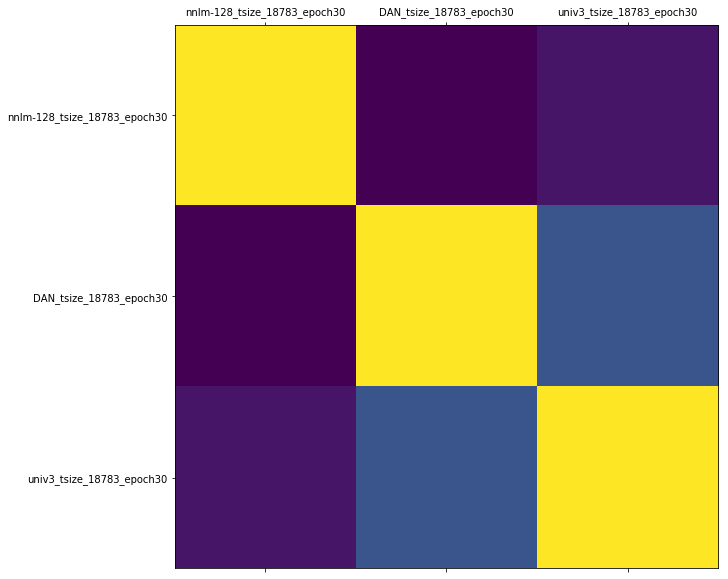

In [108]:
plot_corr(pick)

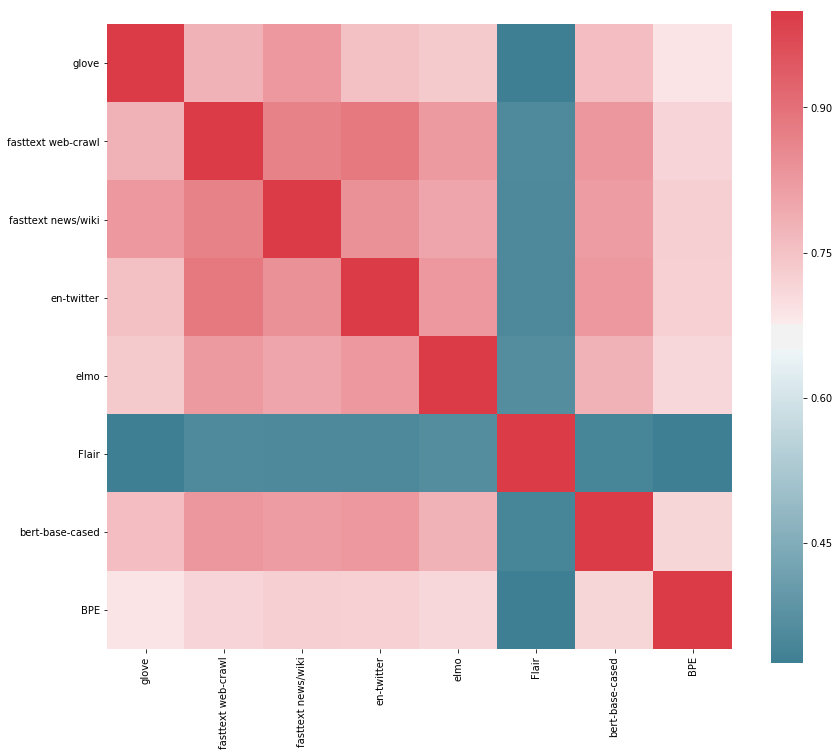

In [97]:
pick = labels
import seaborn as sns

f, ax = plt.subplots(figsize=(14, 12))
corr = pick.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### Compare probabilities

In [122]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    ce = - np.mean(np.log(predictions) * targets) 
    return ce

In [123]:
predictions = np.array([[0.25,0.25,0.25,0.25],
                        [0.01,0.01,0.01,0.96]])
targets = np.array([[0,0,0,1],
                  [0,0,0,1]])
ans = 0.71355817782  #Correct answer
x = cross_entropy(predictions, targets)
print(np.isclose(x,ans))

False


In [131]:
probs = probs.iloc[:,3:6]
probs

,nnlm-128_tsize_18783_epoch30,DAN_tsize_18783_epoch30,univ3_tsize_18783_epoch30
0,"[0.00013908364, 0.9998254, 3.547703e-05]","[2.5715732e-05, 0.9998716, 0.000102616505]","[7.91436e-05, 0.9998338, 8.701929e-05]"
1,"[0.002030536, 0.99750996, 0.00045953243]","[2.547616e-05, 0.9989743, 0.0010002507]","[7.870038e-05, 0.9997701, 0.000151296]"
2,"[0.0006725391, 0.99926144, 6.598066e-05]","[1.7972814e-05, 0.999974, 8.038951e-06]","[6.0237904e-05, 0.9999143, 2.548163e-05]"
3,"[0.0003392862, 0.9996592, 1.5918495e-06]","[1.8328115e-05, 0.9999672, 1.4433712e-05]","[4.4898494e-05, 0.9999287, 2.633073e-05]"
4,"[4.3006254e-05, 0.99995697, 8.022627e-09]","[1.7900435e-05, 0.9999765, 5.5927703e-06]","[7.507247e-05, 0.9999107, 1.421926e-05]"
5,"[0.08427183, 0.8487675, 0.06696065]","[0.0026555285, 0.06760905, 0.9297355]","[0.00016169962, 0.99982136, 1.6898892e-05]"
6,"[0.001172376, 0.9711367, 0.027690923]","[2.252558e-05, 0.99995816, 1.9321673e-05]","[5.2135645e-05, 0.99991536, 3.253769e-05]"
7,"[2.1608248e-06, 0.99978226, 0.00021563252]","[0.00030092022, 0.9585573, 0.04114188]","[6.164825e-05, 0.9998791, 5.9188635e-05]"
8,"[0.00057175703, 0.9981173, 0.0013109304]","[1.6481239e-05, 0.99988806, 9.542799e-05]","[6.790512e-05, 0.99990237, 2.9676981e-05]"
9,"[7.477624e-05, 0.99992514, 1.1235904e-07]","[5.6351914e-06, 0.9999902, 4.1621734e-06]","[6.1978855e-05, 0.9999176, 2.0371614e-05]"


In [134]:
probs.iloc[0]

nnlm-128_tsize_18783_epoch30      [0.00013908364, 0.9998254, 3.547703e-05]
DAN_tsize_18783_epoch30         [2.5715732e-05, 0.9998716, 0.000102616505]
univ3_tsize_18783_epoch30           [7.91436e-05, 0.9998338, 8.701929e-05]
Name: 0, dtype: object

In [135]:
probs.iloc[0][0]

array([0.0001, 0.9998, 0.0000], dtype=float32)

In [178]:
a = probs.iloc[0][0]
b = probs.iloc[0][1]
print(a)
print(b)

[0.0001 0.9998 0.0000]
[0.0000 0.9999 0.0001]


In [188]:
probs

,nnlm-128_tsize_18783_epoch30,DAN_tsize_18783_epoch30,univ3_tsize_18783_epoch30
0,"[0.00013908364, 0.9998254, 3.547703e-05]","[2.5715732e-05, 0.9998716, 0.000102616505]","[7.91436e-05, 0.9998338, 8.701929e-05]"
1,"[0.002030536, 0.99750996, 0.00045953243]","[2.547616e-05, 0.9989743, 0.0010002507]","[7.870038e-05, 0.9997701, 0.000151296]"
2,"[0.0006725391, 0.99926144, 6.598066e-05]","[1.7972814e-05, 0.999974, 8.038951e-06]","[6.0237904e-05, 0.9999143, 2.548163e-05]"
3,"[0.0003392862, 0.9996592, 1.5918495e-06]","[1.8328115e-05, 0.9999672, 1.4433712e-05]","[4.4898494e-05, 0.9999287, 2.633073e-05]"
4,"[4.3006254e-05, 0.99995697, 8.022627e-09]","[1.7900435e-05, 0.9999765, 5.5927703e-06]","[7.507247e-05, 0.9999107, 1.421926e-05]"
5,"[0.08427183, 0.8487675, 0.06696065]","[0.0026555285, 0.06760905, 0.9297355]","[0.00016169962, 0.99982136, 1.6898892e-05]"
6,"[0.001172376, 0.9711367, 0.027690923]","[2.252558e-05, 0.99995816, 1.9321673e-05]","[5.2135645e-05, 0.99991536, 3.253769e-05]"
7,"[2.1608248e-06, 0.99978226, 0.00021563252]","[0.00030092022, 0.9585573, 0.04114188]","[6.164825e-05, 0.9998791, 5.9188635e-05]"
8,"[0.00057175703, 0.9981173, 0.0013109304]","[1.6481239e-05, 0.99988806, 9.542799e-05]","[6.790512e-05, 0.99990237, 2.9676981e-05]"
9,"[7.477624e-05, 0.99992514, 1.1235904e-07]","[5.6351914e-06, 0.9999902, 4.1621734e-06]","[6.1978855e-05, 0.9999176, 2.0371614e-05]"


### Multiclass logloss 
http://wiki.fast.ai/index.php/Log_Loss

In [141]:
from sklearn.metrics import log_loss

In [145]:
type(a)

numpy.ndarray

In [148]:
log_loss(np.array([0,1,2]),np.array([[1,0,0],[0,1,0],[0,0,1]]))

2.1094237467877998e-15

### Cross entropy

In [290]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

predictions = np.array([[0.25,0.25,0.25,0.25],
                        [0.01,0.01,0.01,0.96]])
targets = np.array([[0,0,0,1],
                   [0,0,0,1]])
ans = 0.71355817782  #Correct answer
x = cross_entropy(predictions, targets)
print(np.isclose(x,ans))

True


In [291]:
def mean_cross_entropy(a, b):
    ''' input: takes list of items instead of single softmax'''
    sum = 0
    for i in range(len(a)):
        sum += cross_entropy(a[i], b[i])
    # mean
    return (sum/ len(a))

In [292]:
a = probs.iloc[0][0]
b = probs.iloc[0][1]

In [293]:
cross_entropy(a,b)

0.0004848038467268149

In [180]:
cross_entropy([0.25,0.25,0.5],[0.7, 0.1, 0.2] )

0.41588830713596714

In [181]:
cross_entropy([1,0,0],[0, 1,0] )

6.907422112204443

In [196]:
a = probs.iloc[:,0]
b = probs.iloc[:,1]
c = probs.iloc[:,2]

In [195]:
mean_cross_entropy(a, b)

0.13363556317385797

In [197]:
mean_cross_entropy(a,c)

0.11561411556630624

In [198]:
mean_cross_entropy(b,c)

0.10730167065954697

[[  70   93   10]
 [  60 2168   51]
 [   8   41  499]]


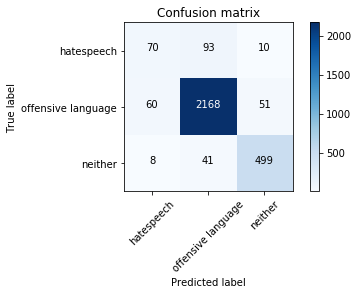

In [161]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, yhat)
CLASSES = ["hatespeech", "offensive language", "neither"]
plot_confusion_matrix(cm, CLASSES)

### Analyze biggest errors

Turn labels into 1-hot. Multiply by predicted prob for labels.


In [ ]:
def oneHot(Y, classes=3):
    """
    Turn input of 1-dim values into 1-hot vector
    in: array([5, 0, 4, 1, 9,...])
    out[0] array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
    """
    #classes = 10
    samples = len(Y)

    #a = np.array([1, 0, 3])
    b = np.zeros((samples, classes))
    b[np.arange(samples), Y] = 1
    return b

In [420]:
def getErrors(model_softmax, y_onehot):
    ''' input predictions of model as softmax, true labels
        count errors for each item'''
    

    comb = model_softmax * y_onehot
    comb = comb.sum(axis=1)

    comb = pd.DataFrame(comb)
    comb.columns=['weight_correct']
    comb['error'] = 1 - comb['weight_correct']
    comb['true_label']=true_labels
    comb['predicted'] = predicted_labels
    
    comb = pd.concat([comb, test[['id', 'text']] ], axis=1)
    return comb 

In [ ]:
def addText(comb)

    return comb = pd.concat([comb, test[['id', 'text']] ], axis=1)

In [421]:
# onehot
onehot = oneHot(true_labels)

model = 5
model_softmax = all[model]['probs']
model_softmax = model_softmax.apply(pd.Series)

comb = getErrors(model_softmax, onehot)
comb




,weight_correct,error,true_label,predicted,id,text
0,0.999834,0.000166,1,1,23437,Wizard turned into a hoe after a break up
1,0.999770,0.000230,1,1,17813,RT MENTION : Captain Kirk hoe !
2,0.999914,0.000086,1,1,2561,MENTION bruh did go out like a bitch thoe lol that should not be his final match
3,0.999929,0.000071,1,1,18228,RT MENTION : RT MENTION : when you tryna get bitches on LinkedIn URL
4,0.999911,0.000089,1,1,23030,Well I wish I could shoot the shit wit u bitches but daddy gotta get dis money . one
5,0.999821,0.000179,1,1,16373,RT MENTION : Niggas can do slope intercept form equations but cant make scrambled fuckin eggs thats a lil backwards
6,0.999915,0.000085,1,1,3560,MENTION He must think you bump pussy . I no mind . I ' ll eat your # thong and make you # squirt like the # geyser .
7,0.999879,0.000121,1,1,2692,"MENTION always eatin good wit my niggah , and good lookin on the cd my boy got some heat now i can bump some bangers"
8,0.999902,0.000098,1,1,23549,Ya last nicca couldn ' t beat it . . I hit it like a free throw !
9,0.999918,0.000082,1,1,12180,It ain ' t nothin to cut that bitch off


In [422]:
# 0 - hate speech
# 1 - offensive language
# 2 - neither

sorted = comb.sort_values(by=['error'], ascending=False)
sorted

,weight_correct,error,true_label,predicted,id,text
931,0.000027,0.999973,2,1,15612,RT MENTION : Todays Horoscope : you ' re still a hoe That is all . have a nice day
2947,0.000035,0.999965,2,1,8932,Define wigga
2083,0.000038,0.999962,2,1,23076,"What else come on on mondays im not finna watch that trash , ive destroyed enuf brain cells ."
1459,0.000043,0.999957,0,2,9708,Giving you that trailer park trash . # transformthursday # ladykimora # vegasqueens # vegasshowgirls URL
640,0.000044,0.999956,2,1,10498,I don ' t know what you been told but I love them project hoes
2617,0.000049,0.999951,0,1,24158,bitches be like i ' m mixed wit Italian Chinese nd African American I be like bitch just cuz you ate ur MENTION ; URL
1082,0.000049,0.999951,0,1,5688,"MENTION May I jump in u ball - less dick - wad ? As a conservative , feminist , disabled vet bitch , I wish u luck with a capital F . MENTION"
1132,0.000051,0.999949,0,2,19439,RT MENTION : There might be a couple cotton pickers on the spurs but they all play unselfish white man basketball
1231,0.000059,0.999941,0,1,20120,"RT MENTION : realest tweet i seen today RT MENTION : MENTION ; . Dyke bitches are rehab for hoes . And once im healed , back to the dick I go"
1651,0.000059,0.999941,2,1,14053,Or she just cant afford winter clothes RT MENTION Summer hoe = winter Muslimah


In [409]:
# predicted probabilities for model X
# dataframe of softmax values, one row per item, cols are classes
model = 5
model_softmax = all[model]['probs']
model_softmax = model_softmax.apply(pd.Series)

# onehot
onehot = oneHot(true_labels)

combined = model_softmax * onehot
# sum 3 classes to one
comb = combined.sum(axis=1)

# error is the amount how far predicted weight for real class was. if given 1 prob to real class error is 0.
comb = pd.DataFrame(comb)
comb.columns=['weight_correct']
comb['error'] = 1 - comb['weight_correct']
comb['true_label']=true_labels
comb['predicted'] = predicted_labels
#comb.head()


predicted_labels = labels.iloc[:,5]
all[5]['model']


'univ3_tsize_18783'

In [408]:
comb

,weight_correct,error,true_label,predicted
0,0.999834,0.000166,1,1
1,0.999770,0.000230,1,1
2,0.999914,0.000086,1,1
3,0.999929,0.000071,1,1
4,0.999911,0.000089,1,1
5,0.999821,0.000179,1,1
6,0.999915,0.000085,1,1
7,0.999879,0.000121,1,1
8,0.999902,0.000098,1,1
9,0.999918,0.000082,1,1


,0,1,2
0,0.000000,0.999919,0.000000
1,0.000000,0.997979,0.000000
2,0.000000,0.998711,0.000000
3,0.000000,0.999517,0.000000
4,0.000000,0.999968,0.000000


0   0.999919
1   0.997979
2   0.998711
3   0.999517
4   0.999968
dtype: float64

In [402]:
# error is the amount how far predicted weight for real class was. if given 1 prob to real class error is 0.
comb = pd.DataFrame(comb)
comb.columns=['weight_correct']
comb['error'] = 1 - comb['weight_correct']
comb['true_label']=true_labels
comb['predicted'] = predicted_labels
comb.head()

,weight_correct,error,true_label,predicted
0,0.999919,0.000081,1,1
1,0.997979,0.002021,1,1
2,0.998711,0.001289,1,1
3,0.999517,0.000483,1,1
4,0.999968,0.000032,1,1


In [403]:
# combine each items id and text
comb = pd.concat([comb, test[['id', 'text']] ], axis=1)
comb

,weight_correct,error,true_label,predicted,id,text
0,0.999919,0.000081,1,1,23437,Wizard turned into a hoe after a break up
1,0.997979,0.002021,1,1,17813,RT MENTION : Captain Kirk hoe !
2,0.998711,0.001289,1,1,2561,MENTION bruh did go out like a bitch thoe lol that should not be his final match
3,0.999517,0.000483,1,1,18228,RT MENTION : RT MENTION : when you tryna get bitches on LinkedIn URL
4,0.999968,0.000032,1,1,23030,Well I wish I could shoot the shit wit u bitches but daddy gotta get dis money . one
5,0.738689,0.261311,1,1,16373,RT MENTION : Niggas can do slope intercept form equations but cant make scrambled fuckin eggs thats a lil backwards
6,0.959847,0.040153,1,1,3560,MENTION He must think you bump pussy . I no mind . I ' ll eat your # thong and make you # squirt like the # geyser .
7,0.999865,0.000135,1,1,2692,"MENTION always eatin good wit my niggah , and good lookin on the cd my boy got some heat now i can bump some bangers"
8,0.996946,0.003054,1,1,23549,Ya last nicca couldn ' t beat it . . I hit it like a free throw !
9,0.999955,0.000045,1,1,12180,It ain ' t nothin to cut that bitch off


In [404]:
# Display whole text of dataframe field and don't cut it
pd.set_option('display.max_colwidth', -1)   

#np.set_printoptions(suppress=True)
pd.set_option('float_format', '{:f}'.format)

In [405]:
# sort by error, decreasing order
sorted = comb.sort_values(by=['error'], ascending=False)

In [406]:

sorted

,weight_correct,error,true_label,predicted,id,text
1231,0.000001,0.999999,0,1,20120,"RT MENTION : realest tweet i seen today RT MENTION : MENTION ; . Dyke bitches are rehab for hoes . And once im healed , back to the dick I go"
406,0.000003,0.999997,0,1,8564,"Can MENTION ; t wait to humble these niggas in the playoffs again . Until then , good job hoes"
1831,0.000009,0.999991,2,2,3124,MENTION MENTION MENTION ha booner has that twitter MENTION ha
1604,0.000009,0.999991,0,1,17299,RT MENTION : Green azz niggas ! ! ! ! & amp ; yall new bitches condone dat sucka activity dat why they keep doin it ! ! !
2337,0.000011,0.999989,0,1,10949,I like how niggas try an come at me and im like do it then bitch and they dont do shit . Pussies
1002,0.000011,0.999989,0,1,9185,Eh bitch ! ? How about you worry about your own psychotic ass . Looks like you need to quote be saved quote from being a noisy bitch MENTION ; MENTION ; MENTION ; # cantStandUcunt
1345,0.000013,0.999987,0,1,22352,They slut for me they kill for me they steal for me and of course it ' ll be yo cash and I ' ll murder that bitch send the body back to yo ass
710,0.000016,0.999984,2,2,532,"quote Mam , Ren MENTION ; e doet in haar rol net of ze ongesteld is Wat is ongesteld ? quote Van dat soort vragen waar je denkt : hoe leg ik die weer uit ."
273,0.000018,0.999982,2,2,12494,"KaasPiet , bloemPiet . ? lol men weet van gekkigheid niet meer hoe ze simpele oplossing tegen racisme moet maken . Zolang maar blanke beslissing is"
1806,0.000024,0.999976,2,2,5481,"MENTION derrrrrrr , 1st of all her songs are actually good compared to the other trash , + + + shes SUCH a showman omg"


In [233]:
# function from https://deepnotes.io/softmax-crossentropy
def cross_entropy(y,X):
#def crossEntropy(y,X):
    """
    X is the output from fully connected layer (num_examples x num_classes)
    y is labels (num_examples x 1)
    	Note that y is not one-hot encoded vector. 
    	It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
    """
    m = y.shape[0]
    #p = softmax(X)
    p=X
    
    # We use multidimensional array indexing to extract 
    # softmax probability of the correct label for each sample.
    # Refer to https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays for understanding multidimensional array indexing.
    log_likelihood = -np.log(  (p[range(m),y])+1e-15)
    loss = np.sum(log_likelihood) / m
    return loss